# Data Analyses

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv("genetics/resources/datathon-pheno.tsv", sep="\t", index_col="s")

In [3]:
df.columns

Index(['target_phenotype', 'bmi', 'age', 'sex', 'pc1', 'pc2', 'pc3', 'pc4',
       'pc5'],
      dtype='object')

# Age

In [4]:
df.groupby("target_phenotype").age.describe().round(1)

,count,mean,std,min,25%,50%,75%,max
target_phenotype,,,,,,,,
0,349.0,70.6,9.7,58.0,62.0,68.0,77.0,96.0
1,743.0,72.7,9.6,58.0,64.0,72.0,80.0,99.0


<AxesSubplot: xlabel='target_phenotype', ylabel='age'>

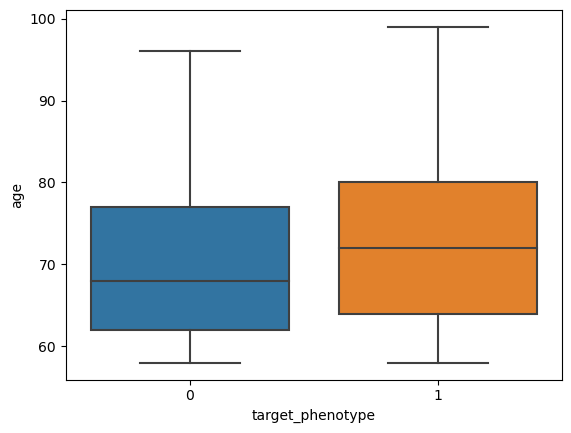

In [5]:
sns.boxplot(x=df.target_phenotype, y=df.age)

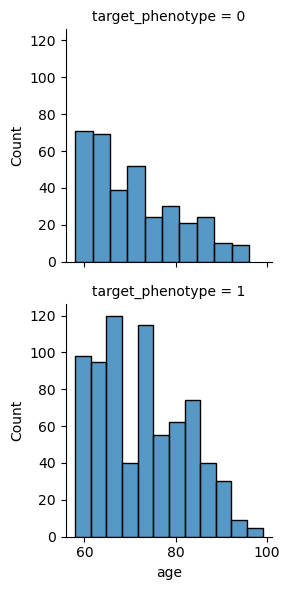

In [6]:
sns.FacetGrid(df, row="target_phenotype").map(sns.histplot, "age")

## BMI

In [ ]:
df.groupby("target_phenotype").bmi.describe().round(1)

,count,mean,std,min,25%,50%,75%,max
target_phenotype,,,,,,,,
0,349.0,26.6,4.4,15.1,23.7,26.3,29.0,40.9
1,743.0,28.7,5.5,15.4,25.1,28.1,31.7,53.6


<AxesSubplot: xlabel='target_phenotype', ylabel='bmi'>

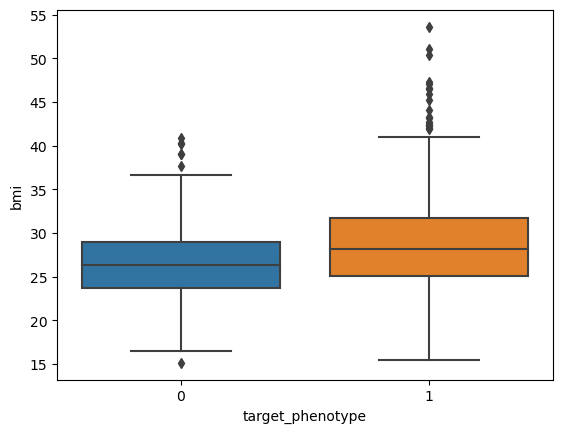

In [42]:
sns.boxplot(x=df.target_phenotype, y=df.bmi)

# Observations: Higher values of BMI are associated with hypertension (class 1).
# Obesity and hypertension are frequently comorbities in patients (cause/effect).
# Could be possibible that PRS are related with hypertension AND obesity? 

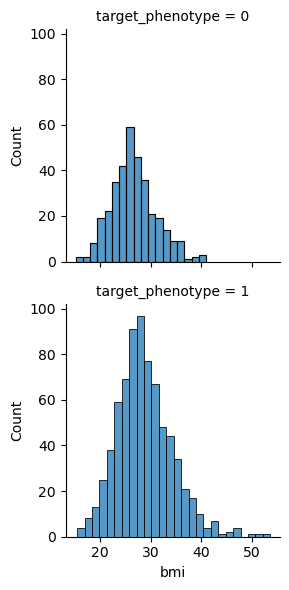

In [23]:
sns.FacetGrid(df, row="target_phenotype").map(sns.histplot, "bmi")

## Sexo

In [29]:
pd.crosstab(df.sex, df.target_phenotype)

target_phenotype,0,1
sex,,
F,198,501
M,151,242


In [33]:
pd.crosstab(df.sex, df.target_phenotype, normalize="index").mul(100).round(1)

target_phenotype,0,1
sex,,
F,28.3,71.7
M,38.4,61.6


In [122]:
pd.crosstab(df.sex, df.target_phenotype, normalize="columns").mul(100).round(1)

target_phenotype,0,1
sex,,
F,56.7,67.4
M,43.3,32.6


In [130]:
df.groupby("sex").age.describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
F,699.0,71.979971,9.372865,58.0,63.0,72.0,79.0,99.0
M,393.0,72.040712,10.237654,58.0,63.0,71.0,80.0,96.0


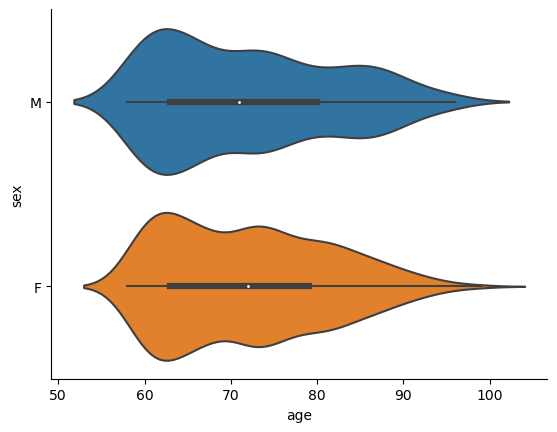

In [131]:
sns.violinplot(data=df, x="age", y="sex")
sns.despine()

## PCA

<AxesSubplot: xlabel='pc1', ylabel='pc2'>

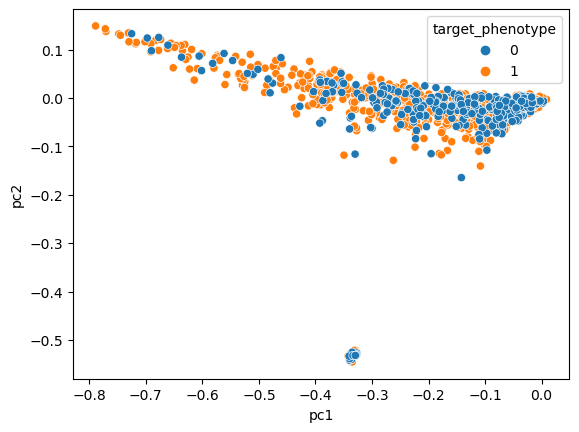

In [36]:
sns.scatterplot(data=df, x="pc1", y="pc2", hue="target_phenotype")

<AxesSubplot: xlabel='pc2', ylabel='pc4'>

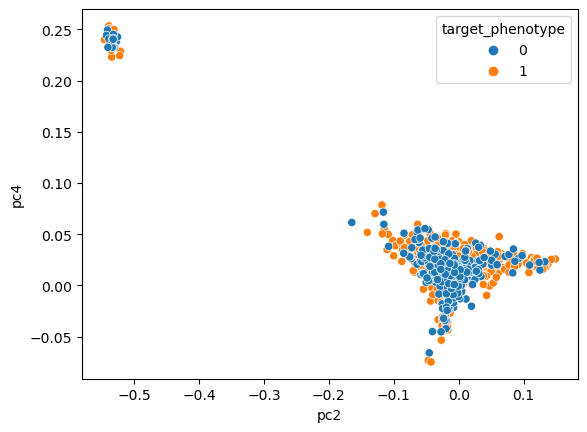

In [20]:
sns.scatterplot(data=df, x="pc2", y="pc4", hue="target_phenotype")

In [38]:
pd.crosstab(df.pc2 < -0.3, df.target_phenotype)

target_phenotype,0,1
pc2,,
False,333,726
True,16,17


In [39]:
pd.crosstab(df.pc2 < -0.3, df.target_phenotype, normalize="index").mul(100).round(1)

target_phenotype,0,1
pc2,,
False,31.4,68.6
True,48.5,51.5


## Baseline analysis with phenotype

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [100]:
pc_cols = ["pc1", "pc2", "pc3", "pc4", "pc5"]
train_df, test_df = train_test_split(df.assign(sex = df.sex == "F").drop(columns=pc_cols), shuffle=True)

In [101]:
rf = RandomForestClassifier()
rf.fit(X=train_df.drop(columns = "target_phenotype"), y=train_df.target_phenotype)

RandomForestClassifier()

In [102]:
pred = pd.Series(
    rf.predict(test_df.drop(columns = "target_phenotype")), 
    index=test_df.index,
    name="prediction")

In [103]:
pd.crosstab(pred, test_df.target_phenotype)

target_phenotype,0,1
prediction,,
0,34,43
1,49,147


In [104]:
pd.crosstab(pred, test_df.target_phenotype, normalize="index").mul(100).round(1)

target_phenotype,0,1
prediction,,
0,44.2,55.8
1,25.0,75.0


In [105]:
pd.crosstab(pred, test_df.target_phenotype, normalize="columns").mul(100).round(1)

target_phenotype,0,1
prediction,,
0,41.0,22.6
1,59.0,77.4


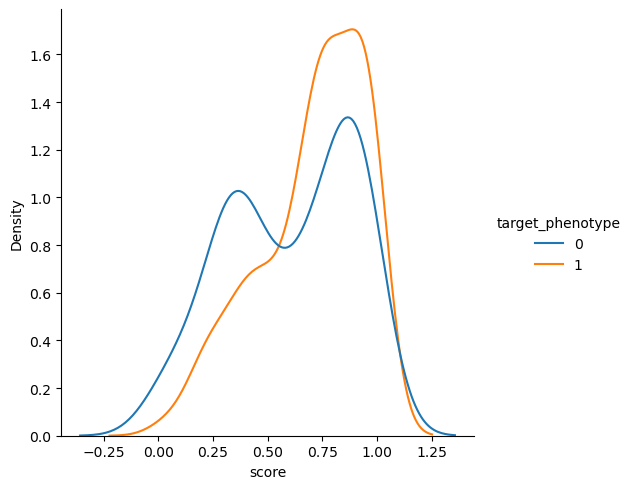

In [106]:
predicted_probs = rf.predict_proba(test_df.drop(columns = "target_phenotype"))[:,1]
sns.displot(
    data=test_df[["target_phenotype"]].assign(score=predicted_probs), 
    x="score", 
    hue="target_phenotype",
    kind="kde",
    common_norm=False
)

In [107]:
print(f"AUC: {roc_auc_score(test_df.target_phenotype, predicted_probs):.3f}")

AUC: 0.602


## Baseline analysis with phenotype and PCA

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [109]:
train_df, test_df = train_test_split(df.assign(sex = df.sex == "F"), shuffle=True)

In [110]:
rf = RandomForestClassifier()
rf.fit(X=train_df.drop(columns = "target_phenotype"), y=train_df.target_phenotype)

RandomForestClassifier()

In [111]:
pred = pd.Series(
    rf.predict(test_df.drop(columns = "target_phenotype")), 
    index=test_df.index,
    name="prediction")

In [112]:
pd.crosstab(pred, test_df.target_phenotype)

target_phenotype,0,1
prediction,,
0,14,13
1,76,170


In [113]:
pd.crosstab(pred, test_df.target_phenotype, normalize="index").mul(100).round(1)

target_phenotype,0,1
prediction,,
0,51.9,48.1
1,30.9,69.1


In [114]:
pd.crosstab(pred, test_df.target_phenotype, normalize="columns").mul(100).round(1)

target_phenotype,0,1
prediction,,
0,15.6,7.1
1,84.4,92.9


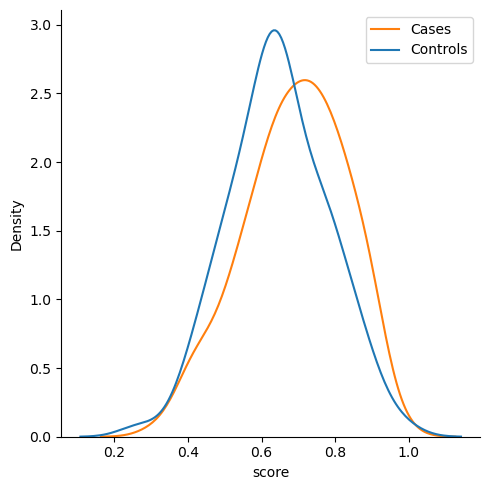

In [49]:
predicted_probs = rf.predict_proba(test_df.drop(columns = "target_phenotype"))[:,1]
sns.displot(
    data=test_df[["target_phenotype"]].assign(score=predicted_probs), 
    x="score", 
    hue="target_phenotype",
    kind="kde",
    common_norm=False,
    legend=False,
)

import matplotlib.pyplot as plt
plt.legend(['Cases', 'Controls'])

In [47]:
print(f"AUC: {roc_auc_score(test_df.target_phenotype, predicted_probs):.3f}")

AUC: 0.602


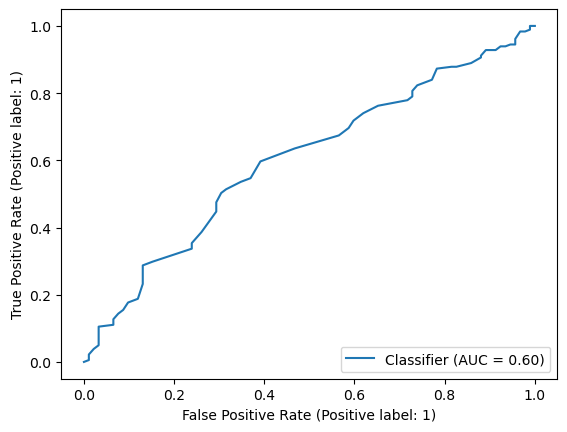

In [48]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(test_df.target_phenotype, predicted_probs)